## Introduction ##

The notebook demonstrates the use of aireo_lib , a python library created as a part of the AIREO (Artificial Intelligence Ready Earth Observation training datasets) project. The project aims to make EO datasets easily accessible for the ML (Machine Learning) community. As such, AIREO specifications (shorthand specs) which define metadata elements to be included with the training dataset are proposed, supplemented by a best-practices document which suggests how to fill those metadata elements. Finally, the library takes all into account and implements specs, best-practices and offers an easy-to-use pythonic interface bridging the gap between EO and ML community.

Therefore, this notebook is divided into two sections, one for the training dataset creator (usually from the EO community) and the other for its user (usually from the ML community). The structure of the notebook is the following:

1) For Creator 

    - Create a [STAC](https://stacspec.org/) catalog object using the library
    
    - Populate metadata elements prescribed by the AIREO specs
    
    - Generate a STAC metadata directory using the library

    - Check AIREO compliance level and metadata completeness

   
2) For User 

    - Create a training dataset object as defined in the library using only the STAC metadata
    
    - Get example instances from the object and other dataset variables like the number of instances, etc.
    
    - Use library's functions to plot the data
    
    - Investigate statistics using the library

#### About the training dataset
SpaceNet7 is a collection of satellite image time series covering 100 different locations in a diverse range of environments. It also includes a set of polygons for each image marking out the building footprints. The image data was collected by Planet satellites at an interval of roughly one month for each location for a period of two years. This is not compeltely consistent across different locations. The data was then manually annotated by a team at SpaceNet to produce the building footprint polygons. The full data from 60 areas was released as a public dataset.

We have simplified the dataset slightly for the purpose of creating a pilot AIREO dataset. We have converted all building polygons to boolean raster masks, and have stored these and the images in netcdf files as time series of raster data, one for each location. We have also standardized image resolution across all locations. This notebook only makes use of 5 AOIs out of 60 for demonstration purposes. 

This dataset can be used to train ML models for the task of automatic building detection in satellite images, and for the tracking of building development over time. 

## AIREO STAC Catalog basics


The AIREO specs propose a hierarchical structure for STAC metadata. It is a two level structure where the dataset is represented by a collection of AOIs (Area Of Interests), hence, the dataset and AOI being the two levels.

1. At the dataset level we have a dataset catalog whose metadata elements are the core elements proposed in the AIREO spec. In addition to it, the common metadata elements across each AOI are also at the dataset level, which we shall call root level henceforth. Here, for each data variable there is a separate json which is a STAC Item by definition and is named using the field_schema metadata element. Additionally, there is also a datasheet file in markdown format at the root level which contains human readable information about the key elements of the dataset.

2. Each AOI has a separate folder within the root level. And in each AOI folder there is a STAC collection representing that AOI and additional json files for each data variable. The additional json files here too, are STAC Items and follow a similar naming convention to the ones at the root level. The assets for each AOI, i.e. the files containing actual data are also in the folder.

The diagram below summarises this hierarchical structure:


```
Root level (dataset)
│
│   DatasetCatalog.json
│   datasheet.md
│   references_output1.json
│   features_input1.json
│   ...
│
│
└───AOI 1
│      1.json (AOI Collection)
│      feature_input1.json
│      reference_output1.json
│      <reference_asset>
│      <feature_asseet>
│   
│   
└───AOI 2
│      ...
│   
│
└───AOI 3
│      ...
│   
...     
```

## Creating a STAC catalog with aireo_lib

The aireo_lib library makes it easier to generate the STAC metadata directory as defined above. Some of the useful functionalities in the library are:
-  Define python dictionaries for metadata at the root level and use a simple function to add it to the STAC catalog. The library validates the data automatically when it is added.

- Similarly, python dictionaries can be defined for each AOI and are also validated automatically.

- Links and assets for all the json files are automatically generated.

- Datasheet is also generated automatically.

- The directory structure is created by the library and assets copied to their respective locations in the hierarchy.

- Evaluating metadata completeness and compliance level.


Follow the code and comments below to understand the steps needed to generate STAC metadata with the library.

In [1]:
import aireo_lib.core
import os
import json
import numpy as np
from tqdm.notebook import tqdm
from shapely import geometry
import shutil
import xarray as xr
from pathlib import Path
from shapely import geometry 
import geopandas as gpd



In [2]:
import os
os.getcwd()

'/home/jovyan/s3/SpaceNet7/Notebook'

In [3]:
# Path to write the STAC root metadata file too
catalog_fn_w_path = '/home/jovyan/s3/SpaceNet7/sp7_stac/TDS.json'

# Creating an empty STAC Catalog object
new_tds_ctl_o = aireo_lib.core.tds_stac_io.DatasetSTACCatalog()

In [4]:
# AOI list int the TDS

dataset_path = '/home/jovyan/s3/SpaceNet7/Data/sp7_sample'

aoi_ids = [aoi_id for aoi_id in os.listdir(dataset_path) if aoi_id[0]!='.'][0:5]

In [5]:
# Creating root metadata dictionary

tds_root_core_metadata_d = {}
tds_root_core_metadata_d['aireo_version'] = "0.0.1-alpha.1"
tds_root_core_metadata_d['title'] = "Images with buildings labelled covering short range of time for each AOI"
tds_root_core_metadata_d['description'] = "Covers 60 areas of interest at 4m resolution with images at monthly intervals. Each image is annotated with polygons labelling buildings. Dataset allows for the monitioring and prediction of building development over time."
tds_root_core_metadata_d['created'] = '2020-07-13'
tds_root_core_metadata_d['license_url_list'] = 'https://creativecommons.org/licenses/by-sa/4.0/' 
tds_root_core_metadata_d['license'] = "CC-BY-SA-4.0"
tds_root_core_metadata_d["providers_name"]= "[SpaceNet LLC]"
tds_root_core_metadata_d["providers_description"] = "Data gathered by Planet satellites, dataset then created by Spacenet "
tds_root_core_metadata_d["providers_roles"] = {"SpaceNet":["processor","host","licensor","producer"], 'AIREO':["producer", "processor" , "host"]}
tds_root_core_metadata_d["providers_url"]= {"Spacenet":"https://spacenet.ai/", 
                            'AIREO': 'https://aireo.net/'}                         
tds_root_core_metadata_d['id'] =  "706cf9e2-bd46-11eb-8529-0242ac130003"
tds_root_core_metadata_d['type'] = "Collection"
tds_root_core_metadata_d['stac_version'] = '1.0.0-beta.2'
tds_root_core_metadata_d['provenance'] = 'Data gathered from Planet satellites and annotatations produced by SpaceNet LLC'
tds_root_core_metadata_d['purpose'] = "Using semantic segmentation track buidling development over time. Segment individual images from each timestep then use this knowledge to track development over time for one AOI."
tds_root_core_metadata_d['tasks'] =  ['Semantic Segmentation']
tds_root_core_metadata_d['data_preprocessing'] = 'Original dataset included images from one AOI as seperate tiff files. We have combined these into one netcdf datacube for each AOI. The building labels were stored as polygons in the original dataset. We have converted to raster masks and have stored them in netcdf datacubes, one for each AOI.'
tds_root_core_metadata_d['funding_info'] = "The AIREO project is funded by ESA. The underlying data was gathered by Planet, then annotated and released by SpaceNet for free use."
tds_root_core_metadata_d['field_schema'] = {'features': {'input1': ['georeferenced_eo_data','georeferenced_eo_datacube']}, 'references': {'output1': ['reference_data']}}
tds_root_core_metadata_d['example_definition'] = "An individual example consists of a single image, and a raster mask representing the buildings visible in the image."
tds_root_core_metadata_d['data_completeness'] = "Dataset is sufficent for task and requires no external sources."
tds_root_core_metadata_d['data_split'] = "Recommend train/test/validation split of 40 AOIs in train, 10 in test and 10 in validation. Should ensure the density of buildings in images is roughly equal for these splits ie. not training on sparsely populated areas then testing on densely populated areas."
tds_root_core_metadata_d['data_sharing'] = "The dataset will be shared on Euro Data Cube (EDC) and can be accessed through jupyter notebooks on EDC."
tds_root_core_metadata_d['compliance_level'] = 'level 1'
tds_root_core_metadata_d['example_window_size'] = 100
tds_root_core_metadata_d['example_stride'] = 80

tds_root_core_metadata_d['data_completeness'] = "The data spans a large geographic range. There are some unusable sections of the images due to cloud cover and instrument malfunction."
tds_root_core_metadata_d['data_split'] = "It is important when splitting data for testing, training and validation, that the density of buildings is similar in each split. For example if we train on sparsely developed areas then our model's performance will likely suffer when tested on highly developed areas."
tds_root_core_metadata_d['data_sharing'] = "The dataset will be shared on Euro Data Cube (EDC) and can be accessed through jupyter notebooks on EDC."
tds_root_core_metadata_d['compliance_level'] = 'level 1'
tds_root_core_metadata_d['links'] =  []

In [6]:
# Make root level feature metadata

g_feature_metadata_d = {}
g_feature_metadata_d['type'] = "Feature"
g_feature_metadata_d['stac_version'] = "1.0.0-beta.2"
g_feature_metadata_d['stac_extensions'] = ["georeferenced_eo_data","georeferenced_eo_datacube"]
g_feature_metadata_d['id'] = "common_feature_metadata"
g_feature_metadata_d['collection'] = "706cf9e2-bd46-11eb-8529-0242ac130003"
    
g_feature_metadata_d["properties"] = {}
# add metadata from georeferencedeodata profile first
g_feature_metadata_d["properties"]['parent_identifier'] = "706cf9e2-bd46-11eb-8529-0242ac130003"
g_feature_metadata_d["properties"]['identifier'] = "Null"
g_feature_metadata_d["properties"]['composed_of'] = "Null"
g_feature_metadata_d["properties"]['linked_with'] = "Null"
g_feature_metadata_d['properties']['product_type'] = "Time series of monthly images for one AOI. Each image shares geometry and bounding box."
g_feature_metadata_d["properties"]["native_product_format"] = "netcdf"
g_feature_metadata_d["properties"]['processing_level'] = "Null"
g_feature_metadata_d["properties"]['auxiliary_dataset_filename'] = "Null"
g_feature_metadata_d['properties']['CRS'] = 'EPSG:3857'

# dimensions of the whole dataset
x_min = -13545862.01592866
y_min = -4510398.55370881
x_max = 16133718.82286585
y_max = 6887891.10417667
g_feature_metadata_d['bbox'] = [x_min,y_min,x_max,y_max]
g_feature_metadata_d['geometry'] = geometry.mapping(geometry.box(x_min,y_min,x_max,y_max,ccw=True))


# now add data for georeferencedeodatacube profile
g_feature_metadata_d["properties"]["dimensions"] = {}
g_feature_metadata_d["properties"]["dimensions"]["x"] = {
                      "type": "spatial",
                      "axis": "x",
                      "extent": [
                        x_min,
                        x_max
                      ],
                      "reference_system": 3857
                    }
g_feature_metadata_d["properties"]["dimensions"]["y"] = {
                      "type": "spatial",
                      "axis": "y",
                      "extent": [
                        y_min,
                        y_max
                      ],
                      "reference_system": 3857
                    }
g_feature_metadata_d["properties"]["dimensions"]["temporal"] = {
                      "type": "temporal",
                      "extent": [
                        "2017-07-01T00:00:00.000000000",
                        "2020-01-01T00:00:00.000000000"
                         ]
                    }
g_feature_metadata_d["properties"]["dimensions"]["spectral"] = {
                      "type": "bands",
                      "values": [
                          "red",
                          "green",
                          "blue"
                      ]
    }
g_feature_metadata_d["properties"]['datetime'] = "2019"


g_feature_metadata_d['links'] = []
g_feature_metadata_d["assets"] = {}

# make feature metadata dictionary 
feature_metadata_d = {}
feature_metadata_d['input1'] = g_feature_metadata_d


In [7]:
# create common reference data    

g_ref_data_metadata_d  = {}
g_ref_data_metadata_d['id'] = f'common_reference_metadata'
g_ref_data_metadata_d['type'] = "Feature"
g_ref_data_metadata_d['stac_version'] = "1.0.0-beta.2"
g_ref_data_metadata_d['stac_extensions'] = ["reference_data"]
g_ref_data_metadata_d['collection'] = "706cf9e2-bd46-11eb-8529-0242ac130003"
g_ref_data_metadata_d['properties'] = {}
g_ref_data_metadata_d['properties']['name'] = 'Reference Metadata'
g_ref_data_metadata_d['properties']['description'] = "The reference data consists of datacubes of raster masks representing the building outlines in the training images. One datacube corresponds to one AOI."
g_ref_data_metadata_d['properties']['type'] = "annotated"
g_ref_data_metadata_d['properties']['task'] = "Semantic Segmentation"
g_ref_data_metadata_d['properties']['classes'] = [[{'BUILDING':255,'NOT_BUILDING':0}]]
g_ref_data_metadata_d['properties']['overviews'] = ["The are dataset covers roughly 40000 square kilometers. 6.94% of this is labelled by this reference data as containing buildings."]
g_ref_data_metadata_d['properties']['collection_method'] = "The reference data was produced by manual annotation of the original satellite images."
g_ref_data_metadata_d['properties']['data_preprocessing'] = "The polygons in the original reference data were converted into rasters with the same dimensions and coordinates as the relevant feature data."
g_ref_data_metadata_d['properties']['CRS'] = 'EPSG:3857'
g_ref_data_metadata_d["properties"]['value'] = 0.
g_ref_data_metadata_d['properties']["orientation"]= "Null"
g_ref_data_metadata_d["properties"]['time_range'] = "2021"
g_ref_data_metadata_d["properties"]['datetime'] = "2019"
from shapely import geometry
g_ref_data_metadata_d['bbox'] = [x_min,y_min, x_max, y_max]
g_ref_data_metadata_d['geometry'] = geometry.mapping(geometry.box(x_min,y_min,x_max,y_max,ccw=True))

g_ref_data_metadata_d['links'] = []
g_ref_data_metadata_d["assets"] = {}

ref_metadata_d = {}
ref_metadata_d['output1'] = g_ref_data_metadata_d

In [8]:
# Check if feature data is compliant

aireo_lib.tds_stac_io.validate_item(feature_metadata_d['input1'])

True

In [9]:
# Add TDS global core elements metadata, and add global level profile metadata to the catalog object.

new_tds_ctl_o.add_tds_root_metadata(tds_root_core_metadata_d, feature_metadata_d, ref_metadata_d)


True

In [10]:
new_tds_ctl_o.valid_tds_root

True

In [11]:
# Adding metadata for each AOI

for aoi_id in tqdm(aoi_ids):
        
    # Dictionary for each AOI collection metadata
    aoi_metadata_d = {}
    aoi_metadata_d['type'] = "Collection"
    aoi_metadata_d["id"] = f"{aoi_id}"
    aoi_metadata_d['stac_version'] = '1.0.0-beta.2'
    aoi_metadata_d['title'] = f"{aoi_id} Collection"
    aoi_metadata_d['description'] = "Datacube of Satellite images for one AOI and datacube of corresponding building masks."
    aoi_metadata_d["license"] = "Various (CC-BY-4.0, Creative Commons CC BY-SA 3.0 IGO)"
    masks_path = dataset_path + '/' + aoi_id + '/building_masks.nc'
    with xr.open_dataarray(masks_path) as masks:
        minx = masks.coords['x'].values[0]
        maxx = masks.coords['x'].values[-1]
        miny = masks.coords['y'].values[0]
        maxy = masks.coords['y'].values[-1]
        start_time = str(min(masks['date'].values))
        end_time = str(max(masks['date'].values))
        unique, counts = np.unique(masks.values,return_counts=True)
        # calculate percentage of images taken up by buildings
        building_percent = 100*(counts[1]/counts[0])
    bbox = [minx,miny,maxx,maxy]
    geo = geometry.mapping(geometry.box(minx,miny,maxx,maxy))
    aoi_metadata_d["bbox"]= bbox
    aoi_metadata_d['geometry'] = geo
    aoi_metadata_d["extent"] = {"spatial" : {"bbox":[bbox]}, 
                          "temporal": {"interval":[[start_time,end_time]]}}
    aoi_metadata_d['time_range'] = start_time+' to '+end_time
    aoi_metadata_d['links'] = []
    aoi_metadata_d["assets"] = {}

    
    
    # Dictionary for each AOI's reference metadata
    aoi_reference_metadata_d = {}
    aoi_reference_metadata_d['id'] = f'reference_metadata_AOI_{aoi_id}'
    aoi_reference_metadata_d['type'] = "Feature"
    aoi_reference_metadata_d['stac_version'] = "1.0.0-beta.2"
    aoi_reference_metadata_d['stac_extensions'] = ["reference_data"]
    aoi_reference_metadata_d['collection'] = "706cf9e2-bd46-11eb-8529-0242ac130003"
    aoi_reference_metadata_d['bbox'] = bbox
    aoi_reference_metadata_d['geometry'] = geo
    aoi_reference_metadata_d['properties'] = {}
    aoi_reference_metadata_d["properties"]['name'] = str(aoi_id)+ " Reference metadata"
    aoi_reference_metadata_d['properties']['description'] = "The reference data consists of time series of raster masks stored in datacubes. These masks cover the buildings present in the corresponding satellite images."
    aoi_reference_metadata_d['properties']['type'] = "Raster"
    aoi_reference_metadata_d['properties']['task'] = "Semantic Segmentation"
    aoi_reference_metadata_d['properties']['classes'] = [[{'BUILDING':255,'NOT_BUILDING':0}]]
    aoi_reference_metadata_d['properties']['overviews'] = [str(building_percent)+"% of this AOI is covered by buildings"]
    aoi_reference_metadata_d['properties']['collection_method'] = "Building polygons were manually created by a team at SpaceNet."
    aoi_reference_metadata_d['properties']['data_preprocessing'] = "The polygons in the original reference data were converted into rasters."
    aoi_reference_metadata_d['properties']['CRS'] = 'EPSG:3857'
    aoi_reference_metadata_d['time_range'] = start_time+' to '+end_time
    aoi_reference_metadata_d["properties"]['value'] = 0
    aoi_reference_metadata_d['properties']["orientation"]= "null"
    aoi_reference_metadata_d["properties"]['datetime'] = start_time

    aoi_reference_metadata_d['links'] = []  
    aoi_reference_metadata_d["assets"] = {}

    aoi_reference_d = {}
    aoi_reference_d['output1'] = aoi_reference_metadata_d
    
    # Dictionary for each AOI's feature metadata
    aoi_feature_data_metadata_d = {}
    aoi_feature_data_metadata_d['type'] = "Feature"
    aoi_feature_data_metadata_d['stac_version'] = "1.0.0-beta.2"
    aoi_feature_data_metadata_d['stac_extensions'] = ["georeferenced_eo_datacube","georeferenced_eo_data"]
    aoi_feature_data_metadata_d['id'] = f'predictive_feature_metadata_AOI_{aoi_id}'
    aoi_feature_data_metadata_d['collection'] = "706cf9e2-bd46-11eb-8529-0242ac130003"
    aoi_feature_data_metadata_d["bbox"]= bbox
    aoi_feature_data_metadata_d['geometry'] = geo
    # first add data from Georeferenced data profile
    aoi_feature_data_metadata_d["properties"] = {}
    aoi_feature_data_metadata_d["properties"]['parent_identifier'] = "706cf9e2-bd46-11eb-8529-0242ac130003"
    aoi_feature_data_metadata_d["properties"]['identifier'] = aoi_id
    aoi_feature_data_metadata_d["properties"]['composed_of'] = "Null"
    aoi_feature_data_metadata_d["properties"]['linked_with'] = "Null"
    aoi_feature_data_metadata_d['properties']['product_type'] = "Time series of monthly images for one AOI. Each image shares geometry and bounding box."
    aoi_feature_data_metadata_d["properties"]["native_product_format"] = "netcdf"
    aoi_feature_data_metadata_d["properties"]['processing_level'] = "Null"
    aoi_feature_data_metadata_d["properties"]['auxiliary_dataset_filename'] = "Null"
    aoi_feature_data_metadata_d["properties"]['identifier'] = str(aoi_id)
    aoi_feature_data_metadata_d["properties"]['datetime'] = start_time
    # add dimension object for datacube profile
    aoi_feature_data_metadata_d["properties"]["dimensions"] = {}
    aoi_feature_data_metadata_d["properties"]["dimensions"]["x"] = {
                      "type": "spatial",
                      "axis": "x",
                      "extent": [
                        minx,
                        maxx
                      ],
                      "reference_system": 3857
                    }
    aoi_feature_data_metadata_d["properties"]["dimensions"]["y"] = {
                      "type": "spatial",
                      "axis": "y",
                      "extent": [
                        miny,
                        maxy
                      ],
                      "reference_system": 3857
                    }
    aoi_feature_data_metadata_d["properties"]["dimensions"]["temporal"] = {
                      "type": "temporal",
                      "extent": [
                        start_time,
                        end_time
                         ]
                    }
    aoi_feature_data_metadata_d["properties"]["dimensions"]["spectral"] = {
                      "type": "bands",
                      "values": [
                          "red",
                          "green",
                          "blue"
                      ]
    }
    
    aoi_feature_data_metadata_d['links'] = []
    aoi_feature_data_metadata_d["assets"] = {}
    
    aoi_feature_d = {}
    aoi_feature_d['input1'] = aoi_feature_data_metadata_d


    aoi_ref_data_asset_path_d = {'output1':dataset_path+'/'+aoi_id+'/building_masks.nc'}
    aoi_feature_asset_path_d = {'input1':dataset_path+'/'+aoi_id+'/images_masked.nc'}
    
    print(new_tds_ctl_o.add_aoi_metadata(aoi_metadata_d=aoi_metadata_d,
                                   aoi_feature_metadata_d=aoi_feature_d,
                                   aoi_ref_data_metadata_d=aoi_reference_d,
                                   aoi_feature_asset_path_d=aoi_feature_asset_path_d,
                                   aoi_ref_data_asset_path_d=aoi_ref_data_asset_path_d))


  0%|          | 0/5 [00:00<?, ?it/s]

True
True
True
True
True


In [12]:
import os

catalog_fn_w_path = '/home/jovyan/s3/SpaceNet7/sp7_stac/TDS.json'

if os.path.exists('../sp7_stac'):
    import shutil
    shutil.rmtree(catalog_fn_w_path.replace('/TDS.json',''))
    
# Write catalog to json    
new_tds_ctl_o.write_TDS_STAC_Catalog(catalog_fn_w_path)


##### Checking AIREO compiance level

In [13]:
new_tds_ctl_o = aireo_lib.core.tds_stac_io.DatasetSTACCatalog.from_TDSCatalog(catalog_fn_w_path)
new_tds_ctl_o.compute_compliance_level()

1

##### Checking metadata completeness

In [14]:
new_tds_ctl_o.report_metadata_completeness()

{'tds_core_metadata': {'required_metadata': 1.0,
  'recommended_metadata': 0.3333333333333333,
  'optional_metadata': 0.23529411764705882}}

#### Defining AOI class

In [15]:
class AOIDatasetSpaceNet:
    """
    This class is to load and to store all data (input features/ reference data) for one area of interest. An area of interest is defined by its bounding box, its geometry, and its time interval. For each specific EO TDS the user needs to create a subclass of AOIDataset and implements its abstract methods.
    """

    def __init__(self, AOI_STAC_collection, TDS_STAC_catalog):

        self.AOI_STAC_collection = AOI_STAC_collection
        self.TDS_STAC_catalog = TDS_STAC_catalog
        self.stride = self.TDS_STAC_catalog.tds_ctl_root_info.tds_root_metadata_d['example_stride']
        self.window_size = self.TDS_STAC_catalog.tds_ctl_root_info.tds_root_metadata_d['example_window_size']
        for eo_feature in self.AOI_STAC_collection.aoi_all_field_metadata.features:
            aoi_feature_asset_path_d = self.AOI_STAC_collection.aoi_all_field_metadata.features[eo_feature].data_asset_w_path
            self.feature_var_name = 'features_'+eo_feature
            self.feature_data = xr.open_dataarray(aoi_feature_asset_path_d)
            
        for reference_data in self.AOI_STAC_collection.aoi_all_field_metadata.references:
            aoi_ref_data_asset_path_d = self.AOI_STAC_collection.aoi_all_field_metadata.references[reference_data].data_asset_w_path
            self.ref_var_name = 'references_'+reference_data
            self.reference_data = xr.open_dataarray(aoi_ref_data_asset_path_d)

        self.timesteps = self.feature_data['date'].values

        self.data = self.feature_data.to_dataset(name=self.feature_var_name)

        # Add second DataArray to existing dataset
        self.data[self.ref_var_name] = self.reference_data
        
        


    def __getitem__(self, index):        

        if index >= len(self):
            sys.exit('index out of range')
            
        # Return examples based on window size and stride metadata

        sample_image = self.feature_data[0]
        x1_ceiling = int((sample_image.shape[1]-self.window_size)/self.stride) +1
        y1_ceiling = int((sample_image.shape[2]-self.window_size)/self.stride) +1
        single_image_examples = x1_ceiling*y1_ceiling
        timestep = int(index/single_image_examples)
        image = self.feature_data[timestep]
        image_index = index - timestep*single_image_examples
        x1 = self.stride*(image_index%x1_ceiling)
        y1 = self.stride*(int(image_index/x1_ceiling))
        x2 = x1+self.window_size
        y2 = y1+self.window_size
        date = self.timesteps[timestep]

        image = image[:,x1:x2,y1:y2]
        building_mask = self.reference_data[timestep,x1:x2,y1:y2]
        
        
        ds = self.data.isel(date=[timestep],band=[0,1,2,3],x=slice(x1,x2),y=slice(y1,y2)).squeeze()
        
        return ds

    # return the number of timesteps multiplied by number of examples in a single timestep 
    def __len__(self):
        sample_image = self.feature_data[0]
        x1_ceiling = int((sample_image.shape[1]-self.window_size)/self.stride) +1
        y1_ceiling = int((sample_image.shape[2]-self.window_size)/self.stride) +1
        single_image_examples = int(x1_ceiling)*int(y1_ceiling)
        return len(self.timesteps)*single_image_examples

    def get_length(self):
        return len(self)

## Dataset user

The user of the dataset can access most of what is offered by the dataset using just its STAC catalog. All he/she needs to do is create a dataset object by passing to it the path to the STAC catalog at the root level. The library automatically reads in all the metadata and loads the assets into the dataset object. Some of the functionalities that a dataset object offers through aireo_lib are:

- Can access an example instance from the dataset which serves as an input-output pair for a Machine Learning algorithm.

- Xarrays are used to store data and give examples.

- Dataset can also return each AOI independently

- Offer basic plotting functions for each variable in the dataset and AOI.

- Some statistics can also be calculated at both the AOI level and whole dataset level.


### Parsing TDS

In [16]:
from aireo_lib.core import EOTrainingDataset

sp7_tds_ctl_fn = Path('/home/jovyan/s3/SpaceNet7/sp7_stac/TDS.json')
    
eo_tds_obj = EOTrainingDataset(sp7_tds_ctl_fn, AOIDatasetSpaceNet)

In [17]:
len(eo_tds_obj)

18000

In [18]:
eo_tds_obj[4204]

<xarray.Dataset>
Dimensions:             (band: 4, x: 100, y: 100)
Coordinates:
  * y                   (y) float64 3.771e+06 3.771e+06 ... 3.77e+06 3.77e+06
  * x                   (x) float64 2.237e+06 2.237e+06 ... 2.238e+06 2.238e+06
    date                datetime64[ns] 2019-11-01
  * band                (band) int32 1 2 3 4
Data variables:
    features_input1     (band, y, x) int16 ...
    references_output1  (y, x) int16 ...

In [19]:
help(eo_tds_obj.get_subset)

Help on method get_subset in module aireo_lib.core:

get_subset(index_arr, data_type='xarray') method of aireo_lib.core.EOTrainingDataset instance
    Returns a subset of examples of the dataset, the return type could be xarray dataset or numpy array.
    
    :param index_arr:
    :param data_type:
    :return:



In [20]:
eo_tds_obj.get_subset([19,1121])

[<xarray.Dataset>
 Dimensions:             (band: 4, x: 100, y: 100)
 Coordinates:
   * y                   (y) float64 2.035e+06 2.035e+06 ... 2.034e+06 2.034e+06
   * x                   (x) float64 -8.563e+06 -8.563e+06 ... -8.563e+06
     date                datetime64[ns] 2018-10-01
   * band                (band) int32 1 2 3 4
 Data variables:
     features_input1     (band, y, x) int16 ...
     references_output1  (y, x) int16 ...,
 <xarray.Dataset>
 Dimensions:             (band: 4, x: 100, y: 100)
 Coordinates:
   * y                   (y) float64 2.032e+06 2.032e+06 ... 2.031e+06 2.031e+06
   * x                   (x) float64 -8.564e+06 -8.564e+06 ... -8.563e+06
     date                datetime64[ns] 2019-04-01
   * band                (band) int32 1 2 3 4
 Data variables:
     features_input1     (band, y, x) int16 ...
     references_output1  (y, x) int16 ...]

In [21]:
aoi_objs = eo_tds_obj.get_aoi_datasets()
len(aoi_objs[1])


3600

### Plotting functions in aireo_lib

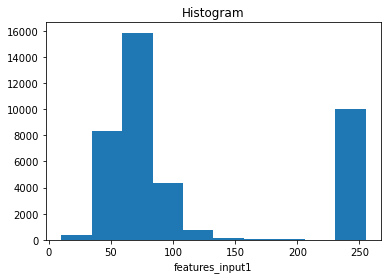

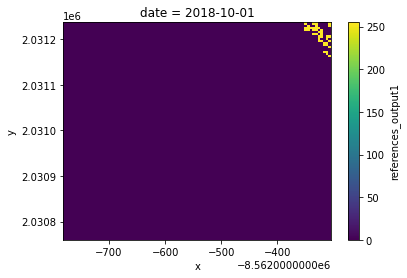

In [30]:
from importlib import reload
from aireo_lib.plotting import EOTDSPlot as aireo_viz

reload(aireo_lib.plotting)
plot_d = aireo_viz.plot_example(EOTDS=eo_tds_obj, 
                       ex_index=128, 
                       field_names=['features_input1', 'references_output1'])

{'features_input1': <Figure size 432x288 with 1 Axes>,
 'references_output1': <Figure size 432x288 with 1 Axes>}

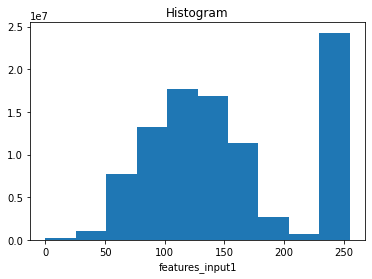

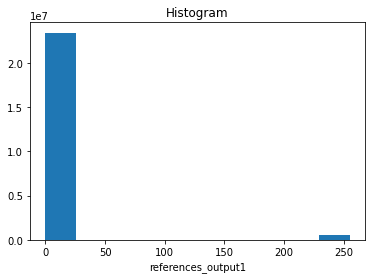

In [32]:
aoi_obj = eo_tds_obj.get_aoi_dataset(2)

# Basic plot of all the variables in an AOI, returns a dict of matplotlib figures

aoi_plots_d = aireo_viz.plot_aoi_dataset(aoi_obj)
aoi_plots_d

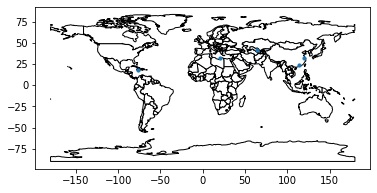

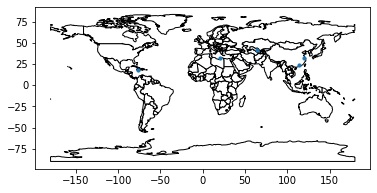

In [36]:
EOTDSPlot.map_aois(eo_tds_obj)

### Statistics functions in aireo_lib


In [37]:
import aireo_lib.statistics
from importlib import reload
reload(aireo_lib.statistics)

<module 'aireo_lib.statistics' from '/home/jovyan/s3/aireo_python_library/src/aireo_lib/statistics.py'>

In [38]:
aireo_lib.statistics.EOTDSStatistics.reference_data_statistics(eo_tds_obj)

{'references_output1_aoi0': Counter({0: 23955211, 255: 1044789}),
 'references_output1_aoi1': Counter({0: 22815686, 255: 2184314}),
 'references_output1_aoi2': Counter({0: 23400203, 255: 599797}),
 'references_output1_aoi3': Counter({0: 24698825, 255: 1301175}),
 'references_output1_aoi4': Counter({0: 23278423, 255: 1721577}),
 'whole_TDS_stats': {0: 118148348, 255: 6851652}}

In [40]:
aireo_lib.statistics.EOTDSStatistics.metadata_statistics(eo_tds_obj)

{'tds_core_metadata': {'required_metadata': 1.0,
  'recommended_metadata': 0.3333333333333333,
  'optional_metadata': 0.23529411764705882}}

In [42]:
aireo_lib.statistics.EOTDSStatistics.dataset_statistics(eo_tds_obj)

{'num_examples': 18000,
 'references_stats': {'references_output1_aoi0': Counter({0: 23955211,
           255: 1044789}),
  'references_output1_aoi1': Counter({0: 22815686, 255: 2184314}),
  'references_output1_aoi2': Counter({0: 23400203, 255: 599797}),
  'references_output1_aoi3': Counter({0: 24698825, 255: 1301175}),
  'references_output1_aoi4': Counter({0: 23278423, 255: 1721577}),
  'whole_TDS_stats': {0: 118148348, 255: 6851652}},
 'features_stats': {'aoi_0_channel_0': {'mean': 123.8392085,
   'std': 85.74647842386017,
   'max': 255,
   'min': 0},
  'aoi_0_channel_1': {'mean': 117.35135975,
   'std': 87.50644128049113,
   'max': 255,
   'min': 0},
  'aoi_0_channel_2': {'mean': 124.858521,
   'std': 84.97290367930557,
   'max': 255,
   'min': 0},
  'aoi_0_channel_3': {'mean': 123.87602725,
   'std': 81.03238719183359,
   'max': 255,
   'min': 10},
  'aoi_0_channel_4': {'mean': 116.57333525,
   'std': 85.32633332354737,
   'max': 255,
   'min': 6},
  'aoi_0_channel_5': {'mean': 124